# Project work in Image Processing and Computer Vision

## Student: Petru Potrimba

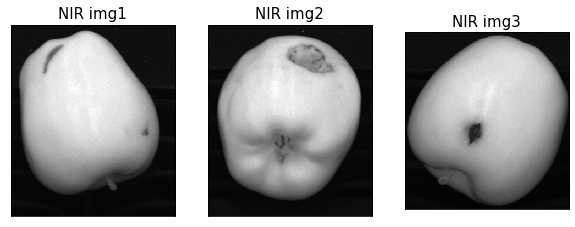

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import heapq
import pandas as pd
import matplotlib.cm as cm
import scipy.io as sio
import random
%matplotlib inline

img1_gray = cv.imread("fruit-inspection-images/first task/C0_000001.png", cv.IMREAD_GRAYSCALE)
img2_gray = cv.imread("fruit-inspection-images/first task/C0_000002.png", cv.IMREAD_GRAYSCALE)
img3_gray = cv.imread("fruit-inspection-images/first task/C0_000003.png", cv.IMREAD_GRAYSCALE)

img1_color = cv.cvtColor(cv.imread("fruit-inspection-images/first task/C1_000001.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB) 
img2_color = cv.cvtColor(cv.imread("fruit-inspection-images/first task/C1_000002.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB) 
img3_color = cv.cvtColor(cv.imread("fruit-inspection-images/first task/C1_000003.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB)

# Plot images
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(img1_gray, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(img2_gray, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img2", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(img3_gray, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img3", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.show()

The first task to achieve is to outline the fruit by generating a binary mask.
For this purpose, the first step is to theshold the image using Otsu's method which consists in maximizing the between-group variance of the background and the foreground.

In [2]:
ret1, otsu_img1 = cv.threshold(img1_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
ret2, otsu_img2 = cv.threshold(img2_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
ret3, otsu_img3 = cv.threshold(img3_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

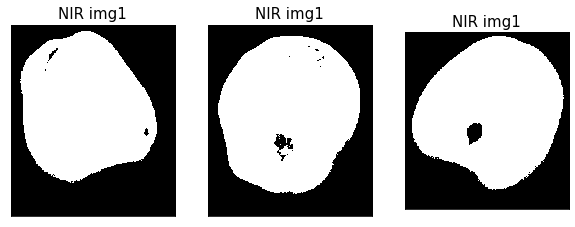

In [3]:
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(otsu_img1, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(otsu_img2, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(otsu_img3, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.show()

Since our apples have holes, we need to fill them to create a mask. For this purpose I used the flood-fill approach.

In [4]:
def flood_fill(tr_img):
    im_floodfill = tr_img.copy()
    h, w = tr_img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv.floodFill(im_floodfill, mask, (0,0), 255);
    im_floodfill_inv = cv.bitwise_not(im_floodfill)
    im_out = tr_img | im_floodfill_inv
    return im_out

def convert_mask_to_RGB(mask):
    return cv.cvtColor(mask, cv.COLOR_GRAY2BGR)

def apply_mask(mask, rgb_img):
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j, 0] == 0:
                rgb_img[i, j, 0] = 0
                rgb_img[i, j, 1] = 0
                rgb_img[i, j, 2] = 0
    return rgb_img

def remove_edges(img_gray, original_color_img_with_mask, mask):
    th, _ = cv.threshold(img_gray, 0, 255, cv.THRESH_OTSU)
    canny = cv.Canny(original_color_img_with_mask, th / 2, th)
    #Erosion
    kernel = np.ones((17, 17), np.uint8) 
    eroded_mask = cv.erode(mask, kernel, iterations = 2)
    img_without_edges = canny.copy()
    for i in range(eroded_mask.shape[0]):
        for j in range(eroded_mask.shape[1]):
            if eroded_mask[i, j] == 0:
                img_without_edges[i, j] = 0
    return img_without_edges

def closing(image_without_edges):
    kernel = np.ones((15,15),np.uint8)
    closing = cv.morphologyEx(image_without_edges, cv.MORPH_CLOSE, kernel)
    return closing

def draw_defects(closed_img, img_color):
    contours, hierarchy = cv.findContours(closed_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    perimeters = []
    for i in range(len(contours)):
        perimeters.append(len(contours[i]))
    two_biggest_numbers = 0
    if len(perimeters) > 3:
        # take two most bigger defects
        two_biggest_numbers = heapq.nlargest(2, perimeters)[1]
    else:
        # take only the biggest defect
        two_biggest_numbers = heapq.nlargest(1, perimeters)[0]
    for i in range(len(perimeters)):
        if perimeters[i] >= two_biggest_numbers:
            for j in range(len(contours[i])):
                # draw contour
                img_color = cv.circle(img_color, center=(contours[i][j][0][0], contours[i][j][0][1]), radius=1, color=(255, 0, 0) , thickness=3)

    return img_color

In [5]:
mask1 = flood_fill(otsu_img1)
mask2 = flood_fill(otsu_img2)
mask3 = flood_fill(otsu_img3)

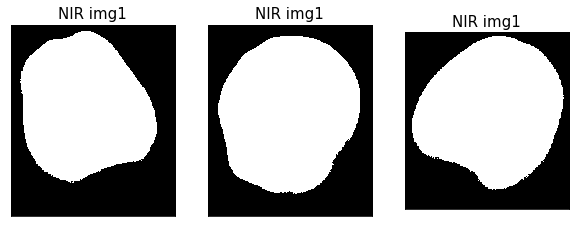

In [6]:
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(mask1, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(mask2, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(mask3, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.show()

Now we are going to apply the resulting masks to the original colored images. To do so, we firstly converth the masks to RGB and then we simply apply the mask which consists in putting to zero the pixels of the original colored images where the mask is zeros.

In [7]:
rgb_mask1 = convert_mask_to_RGB(mask1)
rgb_mask2 = convert_mask_to_RGB(mask2)
rgb_mask3 = convert_mask_to_RGB(mask3)

In [8]:
original_color_img_with_mask1 = apply_mask(rgb_mask1, img1_color)
original_color_img_with_mask2 = apply_mask(rgb_mask2, img2_color)
original_color_img_with_mask3 = apply_mask(rgb_mask3, img3_color)

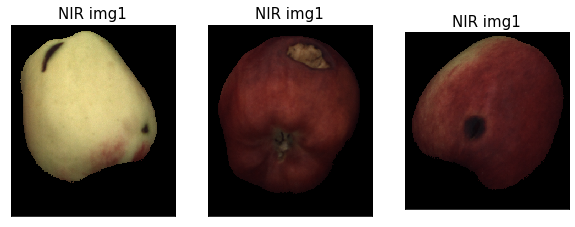

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(original_color_img_with_mask1, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(original_color_img_with_mask2, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(original_color_img_with_mask3, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.show()

Now, the next step is to search for *defects* on each fruit. Since defects have strong edges, we apply an edge extraction algorithm first for extracting them. In this case I used Canny Edge Detection.
Of course, the edge extractor will find also the borders of the apples, which we do not want.
So, in order to remove these borders I create the underneath function `remove_borders` that indeed removes the borders of the apples leaving just the edges of the apples' defects.
To achieve this task, we first erode the previous mask so that, when we apply the mask again, the borders results out of the mask, they goes in the "black" part the mask, so they disapper.

In [10]:
def remove_borders(img_gray, original_color_img_with_mask, mask):
    th, _ = cv.threshold(img_gray, 0, 255, cv.THRESH_OTSU)
    canny = cv.Canny(original_color_img_with_mask, th / 2, th)
    # erosion
    kernel = np.ones((17, 17), np.uint8) 
    eroded_mask = cv.erode(mask, kernel, iterations = 2)
    img_without_edges = canny.copy()
    # apply eroded mask
    for i in range(eroded_mask.shape[0]):
        for j in range(eroded_mask.shape[1]):
            if eroded_mask[i, j] == 0:
                img_without_edges[i, j] = 0
    return img_without_edges

def closing(image_without_edges):
    kernel = np.ones((15,15),np.uint8)
    closing = cv.morphologyEx(image_without_edges, cv.MORPH_CLOSE, kernel)
    return closing

def draw_defects(closed_img, img_color):
    contours, hierarchy = cv.findContours(closed_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    perimeters = []
    for i in range(len(contours)):
        perimeters.append(len(contours[i]))
    two_biggest_numbers = 0
    if len(perimeters) > 3:
        # take two most bigger defects
        two_biggest_numbers = heapq.nlargest(2, perimeters)[1]
    else:
        # take only the biggest defect
        two_biggest_numbers = heapq.nlargest(1, perimeters)[0]
    for i in range(len(perimeters)):
        if perimeters[i] >= two_biggest_numbers:
            for j in range(len(contours[i])):
                # draw contour
                img_color = cv.circle(img_color, center=(contours[i][j][0][0], contours[i][j][0][1]), radius=1, color=(255, 0, 0) , thickness=3)

    return img_color

In [11]:
image_without_edges1 = remove_borders(img1_gray, original_color_img_with_mask1, mask1)
image_without_edges2 = remove_borders(img2_gray, original_color_img_with_mask2, mask2)
image_without_edges3 = remove_borders(img3_gray, original_color_img_with_mask3, mask3)

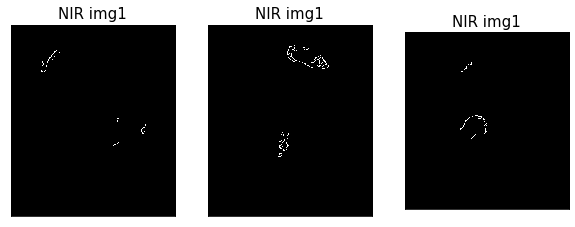

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(image_without_edges1, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(image_without_edges2, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(image_without_edges3, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.show()

Now we have only the edges regarding the apples' defects along with some noise.
Before removing the noise, I apply a closing operation in order to fill the small holes that are present between the edges.

In [13]:
closed_img1 = closing(image_without_edges1)
closed_img2 = closing(image_without_edges2)
closed_img3 = closing(image_without_edges3)

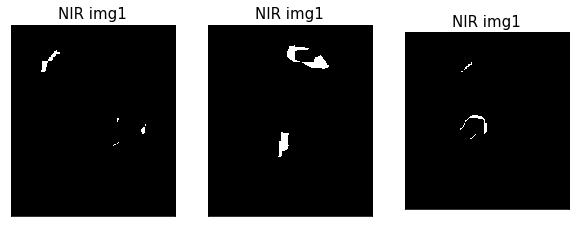

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(closed_img1, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(closed_img2, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(closed_img3, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.show()

Now we have to somehow remove the noise. With the following output, I noted that the perimeter between the areas representing the fruits' defects and the noise varies a lot. So what I did is to consider only the highest perimeter numbers and cut out the smaller values.

Afterwards, to draw the final output, I just drawn a red circle in the presence of the previous defect points considered.

In [15]:
def draw_defects(closed_img, img_color):
    contours, hierarchy = cv.findContours(closed_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    perimeters = []
    for i in range(len(contours)):
        perimeters.append(len(contours[i]))
    two_biggest_numbers = 0
    if len(perimeters) > 3:
        # take two most bigger defects
        two_biggest_numbers = heapq.nlargest(2, perimeters)[1]
    else:
        # take only the biggest defect
        two_biggest_numbers = heapq.nlargest(1, perimeters)[0]
    for i in range(len(perimeters)):
        if perimeters[i] >= two_biggest_numbers:
            for j in range(len(contours[i])):
                # draw contour
                img_color = cv.circle(img_color, center=(contours[i][j][0][0], contours[i][j][0][1]), radius=1, color=(255, 0, 0) , thickness=3)

    return img_color

In [16]:
out1 = draw_defects(closed_img1, img1_color)
out2 = draw_defects(closed_img2, img2_color)
out3 = draw_defects(closed_img3, img3_color)

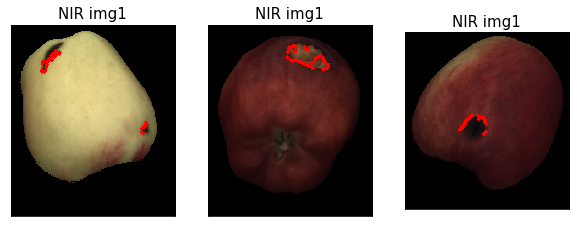

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(out1, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(out2, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(out3, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.show()

# Second task

The second task is about identify russets, or at least some part od them.

In [66]:
img4_color = cv.cvtColor(cv.imread("fruit-inspection-images/second task/C1_000004.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB) 
img5_color = cv.cvtColor(cv.imread("fruit-inspection-images/second task/C1_000005.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB) 

In [67]:
def generate_hsv_mask(img_color):
    img_hsv = cv.cvtColor(img_color, cv.COLOR_BGR2HSV)
    mask = cv.inRange(img_hsv, (99,50,20), (104,255,255))
    res = cv.bitwise_and(img_color,img_color, mask=mask)
    return res

def findClosestCentroids(X, centroids):
    idx = np.zeros((X.shape[0], 1))
    for p in range(X.shape[0]):
        idx[p] = np.argmin(np.linalg.norm(X[p, :] - centroids, axis=1))
    return idx + 1

def computeCentroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    for i in range(K):
        centroids[i, :] = np.mean(X[(idx == (i+1)).nonzero()[0], :], axis=0)
    return centroids

def plotDataPoints(X, idx, K):
    colors = cm.rainbow(np.linspace(0, 1, 100))
    for k in range(1, K + 1):
        plt.scatter(X[(idx == (k)).nonzero()[0], 0], X[(idx == (k)).nonzero()[0], 1], s = 5, color=colors[random.randint(0, 99)])
    
def kMeansInitCentroids(X, K):
    X = np.random.permutation(X)
    return X[:K, :]
    
def drawLine(p1, p2):
    plt.plot(p1, p2, 'ro--')
     
        
def runkMeans(X, initial_centroids, max_iters, plot_clusters_and_centroids = False):
    m = X.shape[0]
    n = X.shape[1]
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros((m, 1))
    for i in range(max_iters):
        idx = findClosestCentroids(X, centroids)       
        centroids = computeCentroids(X, idx, K)
        if plot_clusters_and_centroids == True:
            plotDataPoints(X, idx, K)
    if plot_clusters_and_centroids == True:
        plt.scatter(centroids[:, 0], centroids[:, 1], linewidths=3, s = 40, c = 'black', marker='x')
    return centroids, idx


def run_kmeans_on_img(img): 
    # Divide by 255 so that all values are in the range 0 - 1
    img = img / 255
    img_size = img.shape

    # Reshape the image into an Nx3 matrix where N = number of pixels.
    # Each row will contain the Red, Green and Blue pixel values
    # This gives us our dataset matrix X that we will use K-Means on
    X = img.reshape((img_size[0] * img_size[1], img_size[2]))
    K = 3
    max_iters = 12

    # When using K-Means, it is important the initialize the centroids randomly
    initial_centroids = kMeansInitCentroids(X, K)

    # running K-means
    centroids, idx = runkMeans(X, initial_centroids, max_iters,plot_clusters_and_centroids=False)

    img_compressed = np.zeros((X.shape[0], X.shape[1]))

    # We can now recover the image from the indices (idx) by mapping each pixel
    # (specified by it's index in idx) to the centroid value
    for i, cluster in enumerate(idx):
        img_compressed[i,:] = centroids[int(cluster[0]) - 1,:]

    # Reshape the recovered image into proper dimensions
    img_compressed = img_compressed.reshape((img_size[0], img_size[1], img_size[2]))
    # revert from [0, 1] range to [0, 255]
    img_compressed = (img_compressed*255).astype(np.uint8)
    return img_compressed

def negative_img(img):
    return 255 - img

def draw_russet_kmeans(neg_img, img_color):
    contours, hierarchy = cv.findContours(neg_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    perimeters = []
    for i in range(len(contours)):
        perimeters.append(len(contours[i]))
    two_biggest_numbers = heapq.nlargest(2, perimeters)[1]
    for i in range(len(perimeters)):
        if perimeters[i] == two_biggest_numbers:
            for j in range(len(contours[i])):
                # draw contour
                img_color = cv.circle(img_color, center=(contours[i][j][0][0], contours[i][j][0][1]), radius=1, color=(255, 0, 0) , thickness=12)

    return img_color

To find russets, I used a "grid search" algorithm to find the exact HSV color of the russets of the two apples, these values are the following: (99,50,20), (104,255,255).
This means that the color of the russets stays in that range. 
Then, I generate a HSV mask using those ranges saying basically that "if a pixel has a HSV value that lays in that range, then consider it, othwrise set it to zereo". The generate masks are drawn below.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

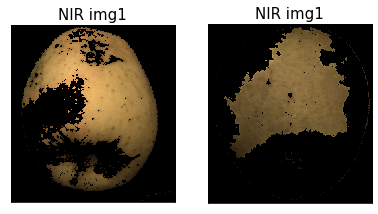

In [68]:
hsv_mask4 = generate_hsv_mask(img4_color)
hsv_mask5 = generate_hsv_mask(img5_color)

plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(hsv_mask4, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(hsv_mask5, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img1", fontsize = 15)
plt.xticks([]), plt.yticks([])

As it can be seen, the russet of the right apple is almost perfectly detected. The same holds for the left apple, however too much noise affects it.
So what I decided to do was to treat the left apple in a different way, in particular using the K-means algorithm to group together the apple's regions that look similar in terms of color. The k used is equal to 3.
The algorithm automatically recognize that the left apple shoud be treated in a different way thanks to a threshold which has been computed in this way:
(the foreground pixels of the left image + the foreground pixels of the right image image)/2. The semantic between this is that: if a HSV mask has a lot of foreground pixels, this is probably an apple that has a lot of noise so another method should be applied to it. The below code computes this threshold.

In [69]:
mask4 = cv.cvtColor(hsv_mask4, cv.COLOR_RGB2GRAY)
kernel = np.ones((5, 5), np.uint8) 
mask4 = cv.erode(mask4, kernel, iterations = 1)

mask5 = cv.cvtColor(hsv_mask5, cv.COLOR_RGB2GRAY)
kernel = np.ones((5, 5), np.uint8) 
mask5 = cv.erode(mask5, kernel, iterations = 1)

Here I compute the threshold in order to understand which algorithm to apply to each single image. If the total foreground pixels are smaller than the threshold, then the russet has been correctly detected and then I am going to draw red pixels on it. Otherwise, it means that there is a lot of noise thus I am going to apply k-means on it.

In [52]:
def count_white_pixels(mask):
    return len(np.where(mask > 0)[0])
threshold = (count_white_pixels(mask4) + count_white_pixels(mask5))/2

In [90]:
def color_russet(img_color, mask, threshold):
    # convert mask from rgb to grayscale
    mask = cv.cvtColor(mask, cv.COLOR_RGB2GRAY)
    # we erode the HSV mask for removing some noise
    kernel = np.ones((5, 5), np.uint8) 
    mask = cv.erode(mask, kernel, iterations = 1)
    out = img_color.copy()
    # color with red dots the HSV found region
    if count_white_pixels(mask) < threshold:
        for i in range(img_color.shape[0]):
            for j in range(img_color.shape[1]):
                if mask[i, j] > 0:
                    out = cv.circle(out, center=(j, i), radius=1, color=(255, 0, 0) , thickness=1)
    else:
        # apply k means for grouping same colors regions
        img_compressed = run_kmeans_on_img(img4_color)
        # img_compressed is ok, it is the image with the region highlited by k means
        # here below we do some workoround of the img_compressed to fix a bug
        img_gray = cv.cvtColor(img_compressed, cv.COLOR_RGB2GRAY)
        ret1, otsu_img = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
        neg_img = negative_img(otsu_img)
        kernel = np.ones((9,9),np.uint8)
        opened_img = cv.morphologyEx(neg_img, cv.MORPH_OPEN, kernel)
        # draw with red dots the k means found region
        out = draw_russet_kmeans(opened_img, img_color.copy())
    return out

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

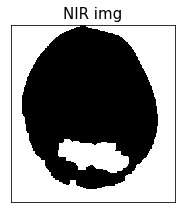

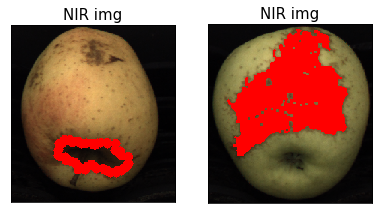

In [91]:
out4 = color_russet(img4_color, hsv_mask4, threshold)
out5 = color_russet(img5_color, hsv_mask5, threshold)
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(out4, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img", fontsize = 15)
plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(out5, cmap='gray', vmin=0, vmax=255)
plt.title("NIR img", fontsize = 15)
plt.xticks([]), plt.yticks([])